In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#downgrade due to a bug when trying to save
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully unin

In [ ]:
import numpy as np 
import pandas as pd
from numpy import load

import matplotlib.pyplot as plt
from matplotlib import cm 
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
from tensorflow.keras import regularizers, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
import time, cv2
from IPython.display import Image, display

#classification
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB3, EfficientNetB7, decode_predictions, EfficientNetB1

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools

from sklearn import metrics

import seaborn as sns

In [ ]:
#chargement de X_brain et y_brain
np.load.__defaults__=(None, True, True, 'ASCII')

#X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_256.npy')
#y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')
X_mask = load('/content/drive/My Drive/Colab_outputs/X_mask_150.npy')

X_train = load('/content/drive/My Drive/Colab_outputs/X_train_lenet.npy')
y_train = load('/content/drive/My Drive/Colab_outputs/y_train_lenet.npy')
X_test = load('/content/drive/My Drive/Colab_outputs/X_test_lenet.npy')
y_test = load('/content/drive/My Drive/Colab_outputs/y_test_lenet.npy')

# Shape de X_brain et y_brain
#print('Shape of X_brain:', X_brain.shape)
#print('Shape of y_brain:',y_brain.shape)
print('Shape of X_mask:',X_mask.shape)

Shape of X_mask: (2501, 150, 150)


In [ ]:
### split des données ###

#X_train, X_test, y_train, y_test = train_test_split(X_brain, y_brain, test_size=0.2, random_state=12345)

# Shape de X_train et y_train
print('Shape of X:', X_train.shape)
print('Shape of y:',y_train.shape)
print('Shape of X:', X_test.shape)
print('Shape of y:',y_test.shape)

Shape of X: (2000, 150, 150, 3)
Shape of y: (2000,)
Shape of X: (501, 150, 150, 3)
Shape of y: (501,)


In [ ]:
# EFFICIENTNET

BATCH_SIZE = 64

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_dataset = train_datagen.flow(X_train,y_train,
                         batch_size = BATCH_SIZE)

test_dataset = test_datagen.flow(X_test, y_test,
                         batch_size = BATCH_SIZE)

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
fl = tfa.losses.SigmoidFocalCrossEntropy()

In [ ]:
from keras import backend as K
tf.config.run_functions_eagerly(True)

def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [ ]:
input_model = Input([None,None,3])

# Modèle Efficientnet-B3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_model) 

# Freezer les couches du Efficientnet-B3
for layer in base_model.layers: 
    layer.trainable = False
    
x = GlobalAveragePooling2D()(base_model.output) 
x = Dense(1024,activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs = base_model.inputs, outputs=x)

#model.compile(loss = "sparse_categorical_crossentropy",
#              optimizer = Adam(learning_rate=1e-4),
#              metrics = ["accuracy"])

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = {i:w for i,w in enumerate(class_weights)}

model.compile(loss = focal_loss_custom(alpha=0.7, gamma=2.0),
              optimizer = "adam",
              metrics = ["accuracy"])

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS = 20

# EarlyStopping qui suit la valeur val_loss, arrête l'entraînement s'il n'y a pas de changement vers val_loss après 3 époques et conserve les meilleurs poids une fois que l'entraînement s'arrête
early_stopping = EarlyStopping(monitor = 'val_loss',
                    min_delta = 0.001,
                    mode = 'min',
                    patience = 5,
                    verbose = 1,
                    restore_best_weights = True)

#ReduceLROnPlateau qui suit la métrique val_loss, divise le coefficient d'apprentissage par 2 si au bout de 3 epochs, val_loss n'a pas varié de 0.01. 
#On attribue une pause de 2 epochs entre 2 cycles
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 5,
                        factor = 0.5, 
                        cooldown = 2,
                        verbose = 1)

history = model.fit(train_dataset, 
                    epochs = EPOCHS,
                    validation_data = test_dataset,
                    callbacks=[reduce_learning_rate, early_stopping])

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 400s 12s/step - loss: 0.0606 - accuracy: 0.8045 - val_loss: 0.0411 - val_accuracy: 0.7166 - lr: 0.0010
Epoch 2/20
32/32 [==============================] - 389s 12s/step - loss: 0.0387 - accuracy: 0.8110 - val_loss: 0.0397 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 3/20
32/32 [==============================] - 372s 12s/step - loss: 0.0338 - accuracy: 0.8455 - val_loss: 0.0352 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 4/20
32/32 [==============================] - 389s 12s/step - loss: 0.0302 - accuracy: 0.8610 - val_loss: 0.0401 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 5/20
32/32 [==============================] - 393s 12s/step - loss: 0.0290 - accuracy: 0.8825 - val_loss: 0.0325 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 6/20
32/32 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.8795 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 [==============================] - 373s 12s/step - loss: 0.

In [ ]:
## on defreeze les 4 dernières couches

def unfreeze_model(model):
    # We unfreeze the top 4 layers while leaving BatchNorm layers frozen
    for layer in base_model.layers[-4:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(lr=1e-4), loss=focal_loss_custom(alpha=0.7, gamma=2.0), metrics=['accuracy'])

unfreeze_model(model)

#for layer in base_model.layers[-4:]:
#    layer.trainable = True

history = model.fit(train_dataset, 
                    epochs = EPOCHS,
                    validation_data = test_dataset,
                    #class_weight = class_weights,
                    callbacks=[reduce_learning_rate, early_stopping]
                    )

#defreeze avant la sauvegarde
#model.save('efficientNetB7.h5')

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


32/32 [==============================] - 390s 12s/step - loss: 0.0244 - accuracy: 0.9040 - val_loss: 0.0365 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 2/20
32/32 [==============================] - 391s 12s/step - loss: 0.0223 - accuracy: 0.9065 - val_loss: 0.0402 - val_accuracy: 0.8782 - lr: 1.0000e-04
Epoch 3/20
32/32 [==============================] - 392s 13s/step - loss: 0.0208 - accuracy: 0.9210 - val_loss: 0.0350 - val_accuracy: 0.8523 - lr: 1.0000e-04
Epoch 4/20
32/32 [==============================] - 384s 12s/step - loss: 0.0205 - accuracy: 0.9110 - val_loss: 0.0373 - val_accuracy: 0.8962 - lr: 1.0000e-04
Epoch 5/20
32/32 [==============================] - 366s 11s/step - loss: 0.0201 - accuracy: 0.9120 - val_loss: 0.0318 - val_accuracy: 0.8463 - lr: 1.0000e-04
Epoch 6/20
32/32 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9250 
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
32/32 [==============================] - 386s

In [ ]:
#from joblib import dump, load

model.save('/content/drive/My Drive/Colab_outputs/efficientNetB3-FL-Last.h5', include_optimizer=False)

# Enregistrement du modèle (à faire après l'entraînement)
#dump(model, '/content/drive/My Drive/Colab_outputs/efficientNetB3-FL.joblib')


In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

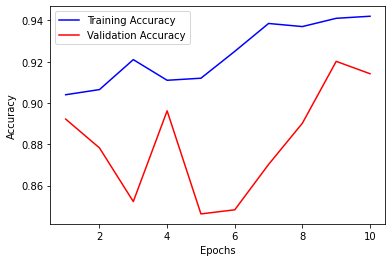

In [ ]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(train_acc)+1, 1),
         train_acc,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , len(val_acc)+1, 1),
         val_acc, 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [ ]:
#prediction 
test_pred = model.predict(X_test)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

16/16 [==============================] - 26s 2s/step


In [ ]:
test_pred_array = np.array(test_pred_class)
pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,380,61
1,16,44


In [ ]:
print(classification_report_imbalanced(y_test, test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.86      0.73      0.91      0.79      0.64       441
          1       0.42      0.73      0.86      0.53      0.79      0.62        60

avg / total       0.89      0.85      0.75      0.86      0.79      0.64       501



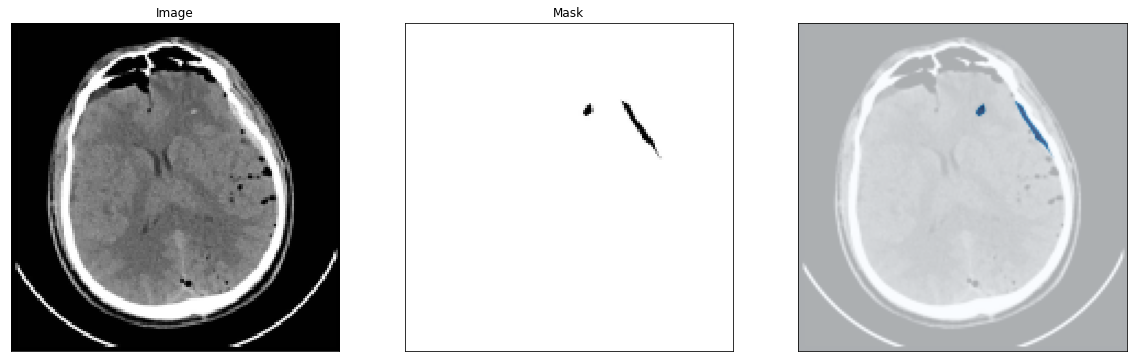

In [ ]:
from numpy import load

last_conv_layer_name = "top_conv"

X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_150.npy')
X_mask= load('/content/drive/My Drive/Colab_outputs/X_mask_150.npy')
y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')

# affichage d'une image aléatoire avec hémorragie
from random import randint

img = X_brain[y_brain == 1][5]
mask = X_mask[y_brain == 1][5]
#plt.imshow(img[randint(0,len(img))],cmap = cm.binary, interpolation='None')
#plt.imshow(img,cmap = cm.binary, interpolation='None')
#plt.imshow(mask,cmap = cm.binary, interpolation='None')

# affichage des images côte à côte
fig = plt.figure(figsize = (20,20))

fig.add_subplot(1,3,1)
plt.imshow(img,cmap = cm.binary, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.title('Image')

fig.add_subplot(1,3,2)
plt.imshow(mask,cmap = cm.binary, interpolation='None')
plt.xticks([])
plt.yticks([])
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.imshow(mask, cmap='Blues', alpha=0.7)

plt.show();

In [ ]:
#algorithme de Grad CAM

def get_img_array(img):
    # `img` is a PIL image of size 299x299
    #img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    #array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(img, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 237ms/step
Predicted: 0


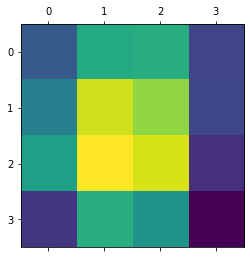

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", np.argmax(preds[0]))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

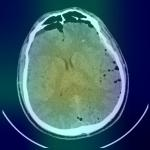

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(150 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img, heatmap)